In [630]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder 

In [631]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train['extra_people']=train['extra_people'].apply(lambda x: float(x.replace('$','')))
# train['transit']=train['transit'].apply(lambda x: 1 if type(x)==str else 0)



test['extra_people']=test['extra_people'].apply(lambda x: float(x.replace('$','')))
# test['transit']=test['transit'].apply(lambda x: 1 if type(x)==str else 0)



#drop outliers
median=train['price'].median()
left=np.quantile(train['price'], 0.001)

right=np.quantile(train['price'],0.9995)


rightdrop=train.loc[train['price']>right].index
leftdrop=train.loc[train['price']<left].index
mostna=train.isna().sum(axis=1).sort_values(ascending=False).head(1000).index


drop=rightdrop.append(leftdrop).append(mostna)

minnight=train.loc[train['minimum_nights']>365].index
drop=drop.append(minnight)
train=train.drop(index=drop).reset_index(drop=True)

train['host_verifications']=train['host_verifications'].apply(lambda x: len(x))
test['host_verifications']=test['host_verifications'].apply(lambda x: len(x))

/Users/xingyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## top 10 corr columns with no modify

In [632]:
train['amenities'] = train['amenities'].apply(lambda x: len(x))

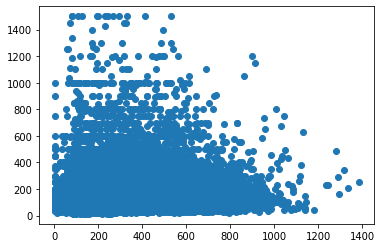

In [633]:
import matplotlib.pyplot as plt
plt.scatter(x=train['amenities'], y=train["price"])
plt.show()

In [634]:
test['amenities'] = test['amenities'].apply(lambda x: len(x))

In [635]:
train['first_review'] = pd.to_datetime(train['first_review'])
train['last_review'] = pd.to_datetime(train['last_review'])
train['days'] = (train['last_review']-train['first_review']).dt.days

In [636]:
test['first_review'] = pd.to_datetime(test['first_review'])
test['last_review'] = pd.to_datetime(test['last_review'])
test['days'] = (test['last_review']-test['first_review']).dt.days

In [637]:
train['host_response_rate'] = train['host_response_rate'].str.replace('%','')
train['host_response_rate'] = train['host_response_rate'].fillna(0)
train['host_response_rate'] = train['host_response_rate'].astype(int)
train['host_response_rate'] = train['host_response_rate'].replace(0,train['host_response_rate'].mean() )
#.fillna((train['host_response_rate'].mean()), inplace=True)

In [638]:
train['host_response_rate']

0         49.398806
1        100.000000
2        100.000000
3         49.398806
4        100.000000
            ...    
32482     49.398806
32483     49.398806
32484     49.398806
32485    100.000000
32486     92.000000
Name: host_response_rate, Length: 32487, dtype: float64

In [639]:
test['host_response_rate'] = test['host_response_rate'].str.replace('%','')
test['host_response_rate'] = test['host_response_rate'].fillna(0)
test['host_response_rate'] = test['host_response_rate'].astype(int)
test['host_response_rate'] = test['host_response_rate'].replace(0,train['host_response_rate'].mean() )
#.fillna((train['host_response_rate'].mean()), inplace=True)

In [640]:
train

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days
0,22267382,Modern and Cozy Large Studio in Brooklyn,Modern large studio with new amenities and app...,Our place is a little quiet sanctuary in the h...,Modern large studio with new amenities and app...,none,"BAM, Barclays, Brooklyn City Point, Fort Green...",NaN,"Subway: 2,3,4,5,A,C,B,Q,G",Washer/Dryer Dishwasher Internet Gym Roof Top ...,"Depending on the time of your visit, I'll be h...","- Please be respectful of our neighbors, no lo...",1910170,Katarina,2012-03-12,"Los Angeles, California, United States","Traveler, Artist, Philanthropist",NaN,49.398806,NaN,f,Fort Greene,1.0,55,t,t,Fort Greene,Brooklyn,Brooklyn,NY,11217,New York,US,United States,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,315,NaN,145.0,2,30.0,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,flexible,f,f,1,0.59,183.0
1,2473861,Royal Harlem TRIPLEX Home 5 Beds,Harlem is back and so gorgeous! Visit and expl...,Harlem is back and so gorgeous! Visit and expl...,Harlem is back and so gorgeous! Visit and expl...,none,HARLEM is a piece of real NY history overflowi...,HARLEM RESTAURANTS Red Rooster Harlem -- excel...,PUBLIC TRANSPORTATION: Conveniently near all p...,The WHOLE ENTIRE HOUSE,NaN,"Smoking, pets and unaccounted guests NOT permi...",8826175,Grover,2013-09-14,"New York, New York, United States",As the owners of the property we have realized...,within an hour,100.000000,NaN,f,Mid-Wilshire,4.0,47,t,t,Harlem,Manhattan,New York,NY,10027,New York,US,United States,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,544,NaN,175.0,3,19.0,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,t,f,moderate,f,f,3,2.47,1649.0
2,25079703,Sunny East Village Studio,"Clean, hip and well designed sun drenched East...",This is a rare East Village studio with it's h...,"Clean, hip and well designed sun drenched East...",none,East Village is one of the last remaining neig...,NaN,NaN,You'll have access to the entire space - it's ...,"Very responsive via phone call, text or email.",NaN,4383563,Zander,2012-12-11,"New York, New York, United States","New York City based, currently working as a te...",within a few hours,100.000000,NaN,f,East Village,1.0,48,t,t,East Village,Manhattan,New York,NY,10009,New York,US,United States,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,184,NaN,180.0,1,0.0,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,f,f,moderate,f,f,1,0.89,80.0
3,9342478,"Beautiful, airy, light-filled room","Private, spacious, comfortable room in 2-bed f...","Big closet, two big windows, tall ceiling and ...","Private, spacious, comfortable room in 2-bed f...",none,One block from Morgan L stop. Super cool area....,NaN,NaN,NaN,NaN,NaN,10406276,Kathleen,2013-12-03,"New York, New York, United States",Australian actress living in New York. Love ex...,NaN,49.398806,NaN,f,Williamsburg,1.0,36,t,t,Williamsburg,Brooklyn,Brooklyn,NY,11237,New York,US,United States,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,213,NaN,42.0,1,0.0,3,1125,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [641]:
[['number_of_reviews','minimum_nights','days','review_scores_value','review_scores_cleanliness',
                  'reviews_per_month','amenities','host_listings_count','calculated_host_listings_count',
                  'accommodates','extra_people','host_response_rate','bedrooms','bathrooms','guests_included',
 'review_scores_location']]

[['number_of_reviews',
  'minimum_nights',
  'days',
  'review_scores_value',
  'review_scores_cleanliness',
  'reviews_per_month',
  'amenities',
  'host_listings_count',
  'calculated_host_listings_count',
  'accommodates',
  'extra_people',
  'host_response_rate',
  'bedrooms',
  'bathrooms',
  'guests_included',
  'review_scores_location']]

## top 10 corr columns plus modified columns

In [642]:
#check corr and select the top 10 
num_col=train.select_dtypes(include=[np.float64,np.int])
top_corr=num_col.corr()['price'].abs().sort_values(ascending=False).drop(['price'])

cate_from=['review_scores_location','review_scores_cleanliness','review_scores_rating','review_scores_value']
top_corr=top_corr[['number_of_reviews','minimum_nights','days','review_scores_value','review_scores_cleanliness',
                  'reviews_per_month','amenities','host_listings_count','calculated_host_listings_count',
                  'accommodates','extra_people','host_response_rate','bedrooms','bathrooms','guests_included',
                   'review_scores_location','beds','host_verifications','review_scores_location']]
# [['beds','bedrooms','extra_people','review_scores_location','extra_people',
#                   'calculated_host_listings_count','host_listings_count','number_of_reviews',
#                   'minimum_nights','reviews_per_month','host_verifications','amenities']]
top_corr

number_of_reviews                 0.030820
minimum_nights                    0.023640
days                              0.037990
review_scores_value               0.034100
review_scores_cleanliness         0.063304
reviews_per_month                 0.021675
amenities                         0.093032
host_listings_count               0.071585
calculated_host_listings_count    0.084497
accommodates                      0.528116
extra_people                      0.102050
host_response_rate                0.040949
bedrooms                          0.398985
bathrooms                         0.300843
guests_included                   0.315443
review_scores_location            0.148141
beds                              0.424567
host_verifications                0.006120
review_scores_location            0.148141
Name: price, dtype: float64

In [643]:
# select features and clean

modify_x=train[top_corr.index]
# modify_x['verfy']=train['host_verifications']
#modify_x['month_review']=train['reviews_per_month']
modify_x['combine']=train[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].mean(axis=1)


modify_y=train['price']

modify_test=test[top_corr.index]
modify_test['combine']=test[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].mean(axis=1)


# modify_test['verfy']=test['host_verifications']
#modify_test['month_review']=test['reviews_per_month']


#deal with na
modify_x['combine'].fillna(0)
modify_test['combine'].fillna(0)
modify_x=modify_x.apply(lambda x: x.fillna(x.median()),axis=1)
modify_test=modify_test.apply(lambda x: x.fillna(x.median()),axis=1)

/Users/xingyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/xingyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [644]:
#clean the train dataset
str_col=pd.DataFrame()
#host location
# str_col['location']=train['city'].fillna('other').str.lower()
# str_col['location']=str_col['location'].str.replace(' ','')
# str_col['location']=str_col['location'].apply(lambda x: x.split(',')[0])
#if the host is superhost
str_col['superhost']=train['host_is_superhost'].fillna('f').str.lower()
#room type
str_col['roomtype']=train['room_type'].str.lower()
#neighborhood
str_col['neighbor']=train['neighbourhood_group_cleansed'].fillna('other').str.lower()
str_col['neighbor']=str_col['neighbor'].str.replace(' ','')
str_col['neighbor']=str_col['neighbor'].apply(lambda x: x.split(',')[0])
#property type
str_col['proper_type']=train['property_type'].fillna('other').str.lower()
str_col['proper_type']=str_col['proper_type'].str.replace(' ','')

# host neighborhood
hostlist=train['host_neighbourhood'].value_counts().head(100).index
str_col['host']=train['host_neighbourhood'].apply(lambda x: x if x in hostlist else 'other')
#zipcode
ziplist=train['zipcode'].value_counts().index
str_col['zip']=train['zipcode'].apply(lambda x: str(x) if x in ziplist else 'nan')
#bed type
str_col['bed']=train['bed_type'].fillna('real bed').str.lower()
#book
#str_col['book']=train['instant_bookable'].str.lower()
#responsetime
# str_col['time']=train['host_response_time'].fillna('nan').str.lower()
#cancellation
# str_col['cancel']=train['cancellation_policy'].str.lower()
#transit
# str_col['transit']=train['transit']
#detail
detailist=train['neighbourhood_cleansed'].value_counts().head().index
str_col['detail']=train['neighbourhood_cleansed'].apply(lambda x: x if x in detailist else 'other')
#profile pic
#str_col['pic']=train['host_has_profile_pic'].str.lower().fillna('f')
#amenities



#additional data
str_col['cancellation_policy']=train['cancellation_policy'].str.lower()
str_col['require_guest_phone_verification']=train['require_guest_phone_verification'].str.lower()
str_col['require_guest_profile_picture']=train['require_guest_profile_picture'].str.lower()
#str_col['require_guest_profile_picture']=train['require_guest_profile_picture'].str.lower()
#str_col['host_neighbourhood']=train['host_neighbourhood'].str.lower()
#str_col['neighbourhood_cleansed']=train['neighbourhood_cleansed'].str.lower()
#str_col['neighbourhood_group_cleansed']=train['neighbourhood_group_cleansed'].str.lower()


In [645]:
train['neighbourhood_cleansed'].isna().sum()

0

In [646]:
#clean the test dataset
str_t=pd.DataFrame()
# str_t['location']=test['city'].fillna('other').str.lower()
# str_t['location']=str_t['location'].str.replace(' ','')
# str_t['location']=str_t['location'].apply(lambda x: x.split(',')[0])
#if the host is superhost
str_t['superhost']=test['host_is_superhost'].fillna('f').str.lower()
#room type
str_t['roomtype']=test['room_type'].str.lower()
# #neighborhood
str_t['neighbor']=test['neighbourhood_group_cleansed'].fillna('other').str.lower()
str_t['neighbor']=str_t['neighbor'].str.replace(' ','')
str_t['neighbor']=str_t['neighbor'].apply(lambda x: x.split(',')[0])
#property type
str_t['proper_type']=test['property_type'].fillna('other').str.lower()
str_t['proper_type']=str_t['proper_type'].str.replace(' ','')
#host neighborhood
str_t['host']=test['host_neighbourhood'].apply(lambda x: x if x in hostlist else 'other')
#zipcode
str_t['zip']=test['zipcode'].apply(lambda x: str(x) if x in ziplist else 'nan')
#bedtype
str_t['bed']=test['bed_type'].fillna('real bed').str.lower()
#booking policy
# str_t['book']=test['instant_bookable'].str.lower()
#responstime
# str_t['time']=test['host_response_time'].fillna('nan').str.lower()
#cancel
# str_t['cancel']=test['cancellation_policy'].str.lower()
#transit
# str_t['transit']=test['transit']
#detail
str_t['detail']=test['neighbourhood_cleansed'].apply(lambda x: x if x in detailist else 'other')
#profile pic
#str_t['pic']=test['host_has_profile_pic'].str.lower().fillna('f')


#additional data
str_t['cancellation_policy']=test['cancellation_policy'].str.lower()
str_t['require_guest_phone_verification']=test['require_guest_phone_verification'].str.lower()
str_t['require_guest_profile_picture']=test['require_guest_profile_picture'].str.lower()
#str_t['require_guest_profile_picture']=test['require_guest_profile_picture'].str.lower()
#str_t['host_neighbourhood']=test['host_neighbourhood'].str.lower()
#str_t['neighbourhood_cleansed']=test['neighbourhood_cleansed'].str.lower()
#str_t['neighbourhood_group_cleansed']=test['neighbourhood_group_cleansed'].str.lower()

In [647]:
#notloc=[i for i in str_t['location'] if i not in str_col['location'].tolist() ]
notnei=[i for i in str_t['neighbor'] if i not in str_col['neighbor'].tolist() ]
notpro=[i for i in str_t['proper_type'] if i not in str_col['proper_type'].tolist() ]

#str_t['location']=str_t['location'].apply(lambda x: 'newyork' if x in notloc else x)
str_t['neighbor']=str_t['neighbor'].apply(lambda x: 'Manhattan' if x in notnei else x)
str_t['proper_type']=str_t['proper_type'].apply(lambda x: 'other' if x in notpro else x)

In [648]:
#str_col['superhost'] = str_col['superhost'].astype(str)
#str_col['host_neighbourhood'] = str_col['host_neighbourhood'].astype(str)
#str_col['host_neighbourhood']

In [649]:
# label encode the columns
# le1 = LabelEncoder()
# le1.fit(str_col['location'])
# str_col['location']= le1.transform(str_col['location']) 

le2 = LabelEncoder()
le2.fit(str_col['superhost'])
str_col['superhost']= le2.transform(str_col['superhost']) 

le3 = LabelEncoder()
le3.fit(str_col['roomtype'])
str_col['roomtype']= le3.transform(str_col['roomtype'])

le4=LabelEncoder()
le4.fit(str_col['neighbor'])
str_col['neighbor']= le4.transform(str_col['neighbor'])

le5=LabelEncoder()
le5.fit(str_col['proper_type'])
str_col['proper_type']= le5.transform(str_col['proper_type'])

le6=LabelEncoder()
le6.fit(str_col['host'])
str_col['host']= le6.transform(str_col['host'])

le7=LabelEncoder()
le7.fit(str_col['zip'])
str_col['zip']= le7.transform(str_col['zip'])

le8=LabelEncoder()
le8.fit(str_col['bed'])
str_col['bed']= le8.transform(str_col['bed'])

# le9=LabelEncoder()
# le9.fit(str_col['book'])
# str_col['book']= le9.transform(str_col['book'])

# le10=LabelEncoder()
# le10.fit(str_col['time'])
# str_col['time']= le10.transform(str_col['time'])

# le11=LabelEncoder()
# le11.fit(str_col['cancel'])
# str_col['cancel']= le11.transform(str_col['cancel'])

# le12=LabelEncoder()
# le12.fit(str_col['transit'])
# str_col['transit']= le12.transform(str_col['transit'])

le13=LabelEncoder()
le13.fit(str_col['detail'])
str_col['detail']= le13.transform(str_col['detail'])

# le14=LabelEncoder()
# le14.fit(str_col['pic'])
# str_col['pic']= le14.transform(str_col['pic'])

le17=LabelEncoder()
le17.fit(str_col['cancellation_policy'])
str_col['cancellation_policy']= le17.transform(str_col['cancellation_policy'])

le18=LabelEncoder()
le18.fit(str_col['require_guest_phone_verification'])
str_col['require_guest_phone_verification']= le18.transform(str_col['require_guest_phone_verification'])

le19=LabelEncoder()
le19.fit(str_col['require_guest_profile_picture'])
str_col['require_guest_profile_picture']= le19.transform(str_col['require_guest_profile_picture'])

# le20=LabelEncoder()
# le20.fit(str_col['host_neighbourhood'])
# str_col['host_neighbourhood']= le20.transform(str_col['host_neighbourhood'])

# le21=LabelEncoder()
# le21.fit(str_col['neighbourhood_cleansed'])
# str_col['neighbourhood_cleansed']= le21.transform(str_col['neighbourhood_cleansed'])

# le22=LabelEncoder()
# le22.fit(str_col['neighbourhood_group_cleansed'])
# str_col['neighbourhood_group_cleansed']= le22.transform(str_col['neighbourhood_group_cleansed'])

In [650]:
# one-hot-encode the columns

#one hot encode
# enc=OneHotEncoder()
# enc.fit(str_col)
# str_encoded=enc.transform(str_col).toarray()
# str_encoded=pd.DataFrame(str_encoded)

str_encoded=pd.DataFrame(str_col)


#combine category and numeric columns
modify_x=pd.concat([modify_x,str_encoded],axis=1)


In [651]:
pd.set_option('display.max_columns', None)
modify_x

,number_of_reviews,minimum_nights,days,review_scores_value,review_scores_cleanliness,reviews_per_month,amenities,host_listings_count,calculated_host_listings_count,accommodates,extra_people,host_response_rate,bedrooms,bathrooms,guests_included,review_scores_location,beds,host_verifications,review_scores_location,combine,superhost,roomtype,neighbor,proper_type,host,zip,bed,detail,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture
0,6.0,7.0,183.0,10.0,10.0,0.59,315.0,1.0,1.0,2.0,30.0,49.398806,1.0,1.0,2.0,10.0,1.0,55.0,10.0,22.857143,0,0,1,18,41,221,4,5,0,0,0
1,137.0,3.0,1649.0,9.0,9.0,2.47,544.0,4.0,3.0,8.0,19.0,100.000000,3.0,1.0,3.0,9.0,5.0,47.0,9.0,20.714286,0,0,2,15,100,50,4,2,2,0,0
2,3.0,2.0,80.0,10.0,9.0,0.89,184.0,1.0,1.0,2.0,0.0,100.000000,0.0,1.0,1.0,10.0,1.0,48.0,10.0,22.571429,0,0,2,1,32,18,4,5,2,0,0
3,0.0,3.0,1.0,1.0,1.0,1.00,213.0,1.0,1.0,1.0,0.0,49.398806,1.0,1.0,1.0,1.0,1.0,36.0,1.0,1.000000,0,1,1,1,96,260,4,4,0,0,0
4,144.0,1.0,1355.0,10.0,10.0,3.14,317.0,1.0,1.0,2.0,14.0,100.000000,1.0,1.0,1.0,10.0,1.0,55.0,10.0,22.428571,1,1,1,1,8,191,4,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32482,19.0,3.0,560.0,8.0,8.0,0.44,42.0,1.0,1.0,2.0,25.0,49.398806,1.0,1.0,1.0,9.0,1.0,50.0,9.0,19.857143,0,1,2,1,0,17,4,5,4,0,0
32483,86.0,3.0,1125.0,9.0,9.0,2.28,465.0,3.0,1.0,8.0,0.0,49.398806,4.0,3.0,1.0,10.0,4.0,36.0,10.0,21.857143,0,0,2,21,64,67,4,5,4,0,0
32484,0.0,180.0,1.0,1.0,1.0,1.00,2.0,1.0,1.0,1.0,0.0,49.398806,1.0,1.0,1.0,1.0,1.0,48.0,1.0,1.000000,0,1,3,15,1,305,4,5,0,0,0
32485,1.0,7.0,0.0,10.0,10.0,0.10,291.0,4.0,3.0,2.0,0.0,100.000000,1.0,1.0,1.0,10.0,1.0,55.0,10.0,22.857143,0,1,2,1,100,62,4,5,2,0,0


In [652]:
# import matplotlib.pyplot as plt
# plt.scatter(x=modify_x['detail'], y=train["price"])
# plt.show()

In [653]:
allre=[]
minmse=1000
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(modify_x, modify_y, test_size=0.3, random_state = 42)
    regr2 = RandomForestRegressor(max_depth=15,n_estimators=80,min_samples_split=6)
    regr2.fit(X_train, y_train)
    modi_pre=regr2.predict(X_test)
    print(np.sqrt(mean_squared_error(y_test, modi_pre)))
    if np.sqrt(mean_squared_error(y_test, modi_pre))<minmse:
        best=regr2
        minmse=np.sqrt(mean_squared_error(y_test, modi_pre))
    allre.append(np.sqrt(mean_squared_error(y_test, modi_pre)))
modi_pre=np.mean(allre)
print('top ten correlation feature with modify RMSE: '+ str(minmse))

81.57047369464175
81.43713711018339
81.51305236697328
81.42070693030067
81.37509158245359
top ten correlation feature with modify RMSE: 81.37509158245359


In [654]:
# predict the test file

 
    
#str_t['location']= le1.transform(str_t['location']) 
str_t['superhost']= le2.transform(str_t['superhost']) 
str_t['roomtype']= le3.transform(str_t['roomtype'])
str_t['neighbor']= le4.transform(str_t['neighbor'])
str_t['proper_type']= le5.transform(str_t['proper_type'])
str_t['host']= le6.transform(str_t['host'])
str_t['zip']= le7.transform(str_t['zip'])
str_t['bed']= le8.transform(str_t['bed'])
#str_t['book']= le9.transform(str_t['book'])
# str_t['time']= le10.transform(str_t['time'])
# str_t['cancel']= le11.transform(str_t['cancel'])
# str_t['transit']= le12.transform(str_t['transit'])
str_t['detail']= le13.transform(str_t['detail'])
#str_t['pic']= le14.transform(str_t['pic'])

str_t['cancellation_policy']= le17.transform(str_t['cancellation_policy'])
str_t['require_guest_phone_verification']= le18.transform(str_t['require_guest_phone_verification'])
str_t['require_guest_profile_picture']= le19.transform(str_t['require_guest_profile_picture'])
#str_t['host_neighbourhood']= le20.transform(str_t['host_neighbourhood'])
#str_t['neighbourhood_cleansed']= le21.transform(str_t['neighbourhood_cleansed'])
# str_t['neighbourhood_group_cleansed']= le22.transform(str_t['neighbourhood_group_cleansed'])

# one-hot-encode the columns

#one hot encode
# enct=enc.transform(str_t).toarray()
# t_encoded=pd.DataFrame(enct)


#combine category and numeric columns
modify_test=pd.concat([modify_test,str_t],axis=1)

test_y=best.predict(modify_test)

In [655]:
output_df = pd.DataFrame()
output_df['Id'] = test['id']
output_df['Predicted'] = test_y
output_df.to_csv('testtest.csv', index = False)

In [656]:
pd.read_csv('testtest.csv')

,Id,Predicted
0,19307997,501.112337
1,20176193,180.609394
2,19485371,63.491154
3,13079990,61.221002
4,22339757,57.580288
...,...,...
17332,22325617,98.015094
17333,8372650,244.371736
17334,3812554,85.326839
17335,18891508,61.273712


In [657]:
# mlp regressor
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor()
nn.fit(X_train, y_train)
modi_pre=nn.predict(X_test)
print('top ten correlation feature with modify RMSE: '+ str(mean_squared_error(y_test, modi_pre)))

test_y=nn.predict(modify_test)


output_df = pd.DataFrame()
output_df['Id'] = test['id']
output_df['Predicted'] = test_y
output_df.to_csv('mlp.csv', index = False)

top ten correlation feature with modify RMSE: 7225.285636343182


/Users/xingyu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [667]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
gbr=GradientBoostingRegressor(n_estimators=600,max_features='sqrt',
                                               learning_rate=0.02,max_depth=7,subsample=0.8)
gbr.fit(X_train, y_train)
modi_pre=gbr.predict(X_test)
print('top ten correlation feature with modify RMSE: '+ str(mean_squared_error(y_test, modi_pre)))

test_y=gbr.predict(modify_test)


output_df = pd.DataFrame()
output_df['Id'] = test['id']
output_df['Predicted'] = test_y
output_df.to_csv('Liu.csv', index = False)

top ten correlation feature with modify RMSE: 6065.5006206434855


In [668]:
pd.read_csv('gbr.csv')

,Id,Predicted
0,19307997,457.444897
1,20176193,127.083099
2,19485371,56.927372
3,13079990,68.592404
4,22339757,48.220775
...,...,...
17332,22325617,67.971840
17333,8372650,248.510030
17334,3812554,84.164825
17335,18891508,56.387614


In [445]:
from sklearn import datasets, ensemble
params = {'n_estimators': 100,
          'max_depth': 15,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print('boosting rmse: '+str(mse))

output_df = pd.DataFrame()
output_df['Id'] = test['id']
output_df['Predicted'] = test_y
output_df.to_csv('boosting.csv', index = False)

boosting rmse: 6744.405761752678


In [1165]:
train.select_dtypes(include=[np.float64,np.int]).columns

Index(['id', 'host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_verifications', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [324]:
train['neighbourhood_cleansed']

'Fort Greene'

In [1299]:
train.columns

Index(['id', 'name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'country_code', 'country', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_ch

In [325]:
train['neighbourhood_cleansed'].value_counts().head(100)

Williamsburg          2753
Bedford-Stuyvesant    2388
Harlem                1888
Bushwick              1671
Upper West Side       1453
                      ... 
Port Morris             32
Bayside                 32
Queens Village          30
St. George              29
Columbia St             28
Name: neighbourhood_cleansed, Length: 100, dtype: int64

In [51]:
train['host_has_profile_pic'].value_counts().sort_values(ascending=False)

t    33393
f       65
Name: host_has_profile_pic, dtype: int64